In [1]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.estimation import estimate, remove_bad_data, chi2_analysis
import pandas as pd
import numpy as np
# from tqdm import tqdm

from scipy import stats
print(pp.__version__)

import matplotlib.pyplot as plt
import ruptures as rpt

from tqdm import tqdm
from numpy import diff
# from julia.PowerModels import run_ac_opf
# from julia.PowerModels import run_ac_opf

2.0.1


In [2]:
def create_measurement_unit(df_measurement, net):
    list_value=[]
    list_std=[]
    for index, row in df_measurement.iterrows():
        if row['element_type'] =='bus':
            if row['meas_type'] =='v':
                mu= net.res_bus.iloc[row['element'],0]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='p':
                mu= net.res_bus.iloc[row['element'],2]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='q':
                mu= net.res_bus.iloc[row['element'],3]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
                
        elif row['element_type'] =='line':
            if row['side']=='from':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                    
                    
        elif row['element_type'] =='trafo':
            if row['side']=='from':
                if row['meas_type'] == 'i':
                    mu =net.res_trafo.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'p':
                    mu =net.res_trafo.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'q':
                    mu =net.res_trafo.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='i':
                    mu =net.res_trafo.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='p':
                    mu =net.res_trafo.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='q':
                    mu =net.res_trafo.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
#         print(mu)  
        value = np.random.normal(mu, sigma, 1)
        list_value.append(value[0])
        list_std.append(sigma)
    df_measurement['value']=list_value
    df_measurement['std_dev']=list_std

    for index, row in df_measurement.iterrows():
        if row['element_type']=='bus':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'])
        elif row['element_type']=='line':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'], side=row['side'])
        elif row['element_type']=='trafo':
            if row['meas_type'] in ['p','q']:
                pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                      std_dev=row['std_dev'], element=row['element'], side=row['side'])
    return df_measurement, net

In [3]:
global upper_bus_accuracy, lower_bus_accuracy, upper_line_accuracy, lower_line_accuracy, upper_trafo_accuracy, lower_trafo_accuracy
upper_bus_accuracy=1.03
lower_bus_accuracy=0.97
upper_line_accuracy=1.05
lower_line_accuracy=0.95
upper_trafo_accuracy=1.05
lower_trafo_accuracy=0.95

In [34]:
#modelling duck curve pattern for solar PV generation
scaling_for_solar=np.array([0,0,0,0,0,0,0.02,0.1,0.3,0.5,0.7,0.8,0.8,1.0,1.0,0.8,0.7,0.4,0.2,0,0,0,0,0,0])
# scaling_for_solar=np.array([np.random.normal(item, 0.01, 60) if item !=0 else np.zeros(60) for item in scaling_for_solar])
scaling_for_solar=np.array([np.random.normal(item, 0.05, 1)[0] if item !=0 else np.zeros(1)[0] for ind in range(len(scaling_for_solar)-1) for item in np.linspace(scaling_for_solar[ind], scaling_for_solar[ind+1],60)])
scaling_for_solar=np.array([value if value >0 else np.zeros(1)[0] for value in scaling_for_solar])
scaling_for_solar.shape=(1,24*60)
scaling_for_load=np.array([0.3,0.2,0.15,0.15, 0.2,0.25,
                          0.4,0.5,0.6,0.7,0.4,0.5,0.6,
                          0.7,0.65,0.55,0.55,0.6,0.7,
                          0.8,0.86,0.9,0.5,0.3])
scaling_for_load=np.array([[np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15)] for item in scaling_for_load])
scaling_for_load.shape=(1,24*60)

In [35]:
scaling_for_solar[0][800:805]=0.1
scaling_for_solar[0][705:710]=0.1
scaling_for_solar[0][677:682]=0.1

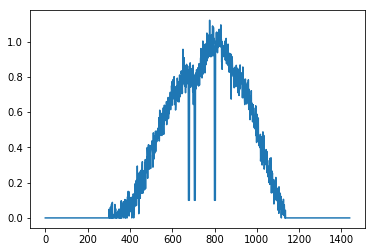

In [36]:
fig, ax = plt.subplots()

ax.plot(range(len(scaling_for_solar[0])), scaling_for_solar[0])
plt.show()

In [38]:
list_PV_loc=[]
list_PV_value=[]
list_PV_detected_loc=[]
list_PV_detected_value=[]
for round in tqdm(range(2), desc='round: '):
    p_mw=np.array([[0,0,0,0]])
    pv_location=np.random.randint(2, size=2)
    list_PV_loc.append(pv_location)
#     print(pv_location)
    for scaling_solar, load_scaling in zip(scaling_for_solar[0],scaling_for_load[0]):
        net = pn.simple_four_bus_system()
        net.sgen.scaling=[scaling_solar*pv_location[0], scaling_solar*pv_location[1]]
        net.sgen.q_mvar[:]=0
        net.sgen.p_mw=np.random.randint(50, size=2)/1000
        net.load.scaling=[load_scaling, load_scaling]
        pp.runpp(net)
        df_measurement=pd.DataFrame()
        df_measurement['meas_type']=['v','v','p','p','q','q','i','i']
        df_measurement['element_type']=['bus','bus','line','line','line','line','line','line']
        df_measurement['element']=[2,3,0,1,0,1,0,1]
        df_measurement['side']=['None','None','from','from','from','from','from','from']
        df_measurement, net = create_measurement_unit(df_measurement, net)
        success = estimate(net, init="slack", calculate_voltage_angles=True, zero_injection=[1])
        new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
        p_mw=np.concatenate((p_mw, new_mw), axis=0)

    df=pd.DataFrame()
    df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
    bus_has_solar_PV=[]
    for bus in range(0,len(p_mw[0])):
        df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
        corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
        print('correlation at bus {} is: {}'.format(bus, corr))
        if corr <-0.2:
            bus_has_solar_PV.append(bus)
    list_PV_detected_loc.append(bus_has_solar_PV)
    #combine solar scaling and p_mw at solar located bus
    new_p_mw=p_mw.copy()
    new_p_mw=new_p_mw.transpose()
    # new_p_mw[2].shape=(1441,1)
    my_array=np.array([scaling_for_solar[0]]).T.copy()
    for located_bus in bus_has_solar_PV:
        my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

    algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(my_array[:])
    my_bkps = algo.predict(pen=1)
    for bus in bus_has_solar_PV:
        sum_value=np.array([])
        size_pv=[]
        for period in my_bkps[:-1]:
        #     print(period)
            value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
            if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
        #         print(value)
                sum_value = np.append(sum_value, value)
            size_pv.append(sum_value.sum()/len(sum_value))
        print('bus :', bus, 'has solar PV size: ', sum_value.sum()/len(sum_value)) 
    list_PV_detected_value.append(size_pv)

[1 0]


KeyboardInterrupt: 

array([0.017, 0.036])

array([0, 0])